# L'approssimazione di una funzione mediante un MLP con uno strato interno

Luca Mari, gennaio 2025  

Quest'opera è distribuita con <a href="http://creativecommons.org/licenses/by-nc-sa/4.0" target="_blank">Licenza Creative Commons Attribuzione - Non commerciale - Condividi allo stesso modo 4.0 Internazionale</a>.  
<img src="https://creativecommons.it/chapterIT/wp-content/uploads/2021/01/by-nc-sa.eu_.png" width="100">

**Obiettivo**: comprendere, a partire da un esempio concreto, che una rete neurale deve includere degli elementi non lineari per poter approssimare appropriatamente anche delle semplici funzioni non lineari.  
**Precompetenze**: basi di Python; almeno qualche idea di analisi matematica.

> Per eseguire questo notebook, supponiamo con VSCode, occorre:
> * installare un interprete Python
> * scaricare da https://code.visualstudio.com/download e installare VSCode
> * eseguire VSCode e attivare le estensioni per Python e Jupyter
> * ancora in VSCode:
>     * creare una cartella di lavoro e renderla la cartella corrente
>     * copiare nella cartella il file di questa attività: [onehidden.ipynb](onehidden.ipynb)
>     * aprire il notebook `onehidden.ipynb`
>     * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
>     * installare il modulo Python richiesto, eseguendo dal terminale:  
>         `pip install torch`

Abbiamo già considerato che una rete neurale è l'implementazione di una funzione parametrica $Y = f(X; K)$, e può essere intesa come uno strumento di approssimazione di funzioni $F(X)$ date: attraverso un opportuno addestramento, si trovano i valori appropriati dei parametri $K$ in modo che $f(X; K) \approx F(X)$. E abbiamo sperimentato che una rete costituita da un solo neurone a comportamento lineare non è in grado di approssimare in modo accettabile anche funzioni molto semplici.

Continuando ad assumere di voler approssimare funzioni $F: \mathbb{R} \times \mathbb{R} \rightarrow \mathbb{R}$, rendiamo allora la rete un poco più complessa, introducendo tra i due input e l'output uno o più _nodi_ (d'ora in poi chiameremo così i neuroni) di uno _strato interno_ (_hidden layer_), con la condizione che la rete sia _fully connected_:  
-- tutti gli input sono connessi a tutti i nodi dello strato interno, e  
-- tutti i nodi dello strato interno sono connessi al nodo di output.  
Se per esempio lo strato interno ha due nodi, la struttura della rete è dunque:

![rete](onehidden.drawio.svg)

Per costruire e operare sulla rete useremo `PyTorch`: importiamo perciò i moduli Python che saranno necessari e verifichiamo se è disponibile una GPU per eseguire la rete.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

Implementiamo la rete in modo da poter gestire questa struttura.

In [2]:
class OneHidden(nn.Module):
    def __init__(self):
        super(OneHidden, self).__init__()
        self.hidden = nn.Linear(2, 2)   # connessioni dai 2 input ai 2 neuroni dello strato interno
        self.output = nn.Linear(2, 1)   # connessioni dai 2 neuroni dello strato interno all'unico output

        self.loss = nn.MSELoss()        # funzione di errore: Mean Squared Error
        self.optimizer = optim.SGD(self.parameters(), lr=0.01) # ottimizzatore: Stochastic Gradient Descent # type: ignore

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        return x

    def set_learning_rate(self, learning_rate):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = learning_rate        

    def train(self, x, y, epochs, repeat):
        print(f'\n*** Addestramento ***\nepoca\terrore')
        for epoch in range(epochs):
            self.optimizer.zero_grad()  # azzera i gradienti
            output = self(x)            # calcola l'output
            loss = self.loss(output, y) # calcola la funzione di errore
            loss.backward()             # calcola i gradienti
            self.optimizer.step()       # aggiorna i valori dei parametri
            if (epoch+1) % repeat == 0:
                print(f'{epoch+1}\t{loss.item():.3f}')

    def predict(self, examples, fun):
        print('\n*** Inferenza ***')
        x_test = examples
        y_test = self(x_test)           # calcola la previsione
        y_true = self.calc_fun(fun, x_test)
        print('x1\tx2\ty\ty prev\terrore')
        for i in range(x_test.size(0)):
            x1, x2 = x_test[i][0].item(), x_test[i][1].item()
            y, y_hat = y_true[i].item(), y_test[i].item()
            print(f'{x1:.2f}\t{x2:.2f}\t{y:.2f}\t{y_hat:.2f}\t{y - y_hat:.2f}')
        print(f'Errore quadratico medio: {torch.mean((y_test - y_true)**2):.5f}')

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def print_parameters(self):
        for name, param in self.named_parameters():
            print(name, param.data)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def calc_fun(self, fun, X):
        return fun(X[:, 0], X[:, 1]).view(-1, 1)


model = OneHidden()
print('I parametri della rete sono:'); model.print_parameters()
print(f"Questa è dunque una rete con {model.count_parameters()} parametri.")

I parametri della rete sono:
hidden.weight tensor([[ 0.6418, -0.6420],
        [ 0.0440, -0.0221]])
hidden.bias tensor([ 0.3122, -0.5707])
output.weight tensor([[-0.3797, -0.2442]])
output.bias tensor([0.7009])
Questa è dunque una rete con 9 parametri.


Costruiamo il training set, negli input come un certo numero di coppie di numeri casuali e nel corrispondente output, dopo aver scelto la funzione da approssimare. Supponiamo sia la funzione massimo tra due numeri, che avevamo visto un singolo neurone non riesce ad approssimare in modo accettabile.  
Quindi, dopo aver assegnato i valori agli iperparametri, addestriamo la rete.

In [4]:
def fun(x1, x2): return torch.max(x1, x2) # funzione da approssimare, in questo caso il massimo tra due numeri

def examples(n): return (10 * torch.rand(n, 2) - 5) # genera n esempi nella forma ognuno di una coppia di numeri casuali tra -5 e 5
num_examples = 100                      # numero di esempi per il training set
X = examples(num_examples)              # calcola i valori degli esempi: input del training set
Y = model.calc_fun(fun, X)              # calcola il valore della funzione per ogni esempio: output del training set

num_epochs = 1000                       # numero di ripetizioni del processo di addestramento
repeat = 100                            # numero di ripetizioni dopo le quali visualizzare l'errore
model.reset_parameters()                # reinizializza i parametri della rete
model.set_learning_rate(0.003)          # imposta il learning rate
model.train(X, Y, num_epochs, repeat)   # addestra la rete


*** Addestramento ***
epoca	errore
100	1.479
200	1.417
300	1.415
400	1.415
500	1.415
600	1.415
700	1.415
800	1.415
900	1.415
1000	1.415


È chiaro che la presenza dello strato interno, e quindi dei parametri corrispondenti, non ha migliorato le cose: nonostante un numero più elevato di ripetizioni, il processo di addestramento non è in grado di ridurre l'errore a valori accettabili. La ragione dovrebbe essere chiara: stiamo cercando di approssimare una funzione non lineare con una combinazione lineare di funzioni lineari, che è a sua volta una funzione lineare.

La soluzione è di introdurre un qualche genere di non linearità nella rete: la si realizza modificando la funzione calcolata dai nodi dello strato interno, componendo a essa una funzione non lineare:

![rete2](onehidden2.drawio.svg)

In [6]:
def forward(self, x):
    x = self.hidden(x)
    x = torch.relu(x)                   # funzione di attivazione non lineare: ReLU
    x = self.output(x)
    return x

OneHidden.forward = forward
model = OneHidden()

Ripetiamo il processo di addestramento su questa nuova struttura. 

In [17]:
num_epochs = 50000                      # numero di ripetizioni del processo di addestramento
repeat = 5000                           # numero di ripetizioni dopo le quali visualizzare l'errore
model.reset_parameters()                # reinizializza i parametri della rete
model.set_learning_rate(0.003)          # imposta il learning rate
model.train(X, Y, num_epochs, repeat)   # addestra la rete


*** Addestramento ***
epoca	errore
5000	0.319
10000	0.007
15000	0.002
20000	0.001
25000	0.000
30000	0.000
35000	0.000
40000	0.000
45000	0.000
50000	0.000


Mostriamo i valori dei parametri per come sono stati imparati e proviamo a usare la rete così addestrata.

In [21]:
print('I parametri della rete sono:')
model.print_parameters()

model.predict(examples(10), fun)        # inferenza dopo l'addestramento

I parametri della rete sono:
hidden.weight tensor([[-8.6612e-01,  8.6611e-01],
        [-4.4553e-01, -6.4428e-06]])
hidden.bias tensor([-5.0094e-05,  2.1959e+00])
output.weight tensor([[ 1.1546, -2.2445]])
output.bias tensor([4.9287])

*** Inferenza ***
x1	x2	y	y prev	errore
1.11	-3.23	1.11	1.11	-0.00
-4.70	-0.49	-0.49	-0.49	0.00
1.90	1.67	1.90	1.90	-0.00
0.77	1.06	1.06	1.06	-0.00
-1.17	1.87	1.87	1.87	0.00
-4.68	-0.92	-0.92	-0.92	0.00
3.69	3.36	3.69	3.69	-0.00
-2.43	0.54	0.54	0.54	0.00
-0.28	-0.47	-0.28	-0.28	-0.00
3.00	-4.04	3.00	3.00	0.00
Errore quadratico medio: 0.00000


Possiamo anche visualizzare la funzione che la rete calcola.

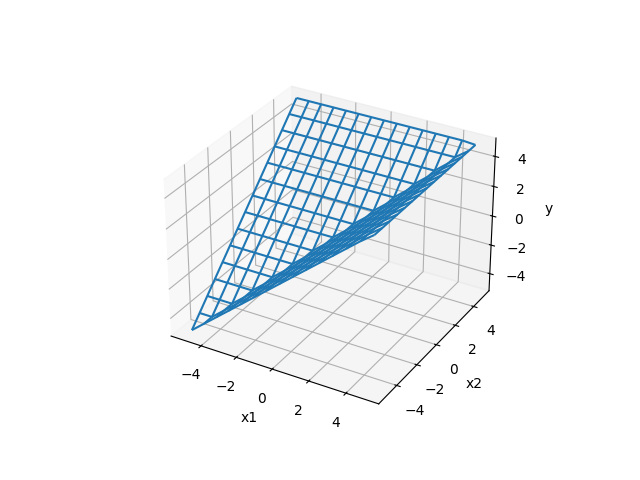

In [ ]:
# %matplotlib ipympl
%matplotlib widget
import matplotlib.pyplot as plt

n = 15                                  # numero di punti per l'asse x e per l'asse y
X1 = torch.linspace(-5, 5, n).view(-1, 1).repeat(1, n).T
X2 = torch.linspace(-5, 5, n).view(-1, 1).repeat(1, n)
XX1 = X1.reshape(n * n)
XX2 = X2.reshape(n * n)
X_test = torch.stack((XX1, XX2), dim=1)
Y_test = model(X_test)                  # calcola la previsione
Y1 = Y_test.reshape(n, n)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X1.detach().numpy(), X2.detach().numpy(), Y1.detach().numpy()) # type: ignore
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y') # type: ignore
plt.show()

Abbiamo addestrato la rete per argomenti della variabile indipendente nell'intervallo $[-5, 5]$. È interessante esplorare come essa si comporta per argomenti al di fuori di questo intervallo...

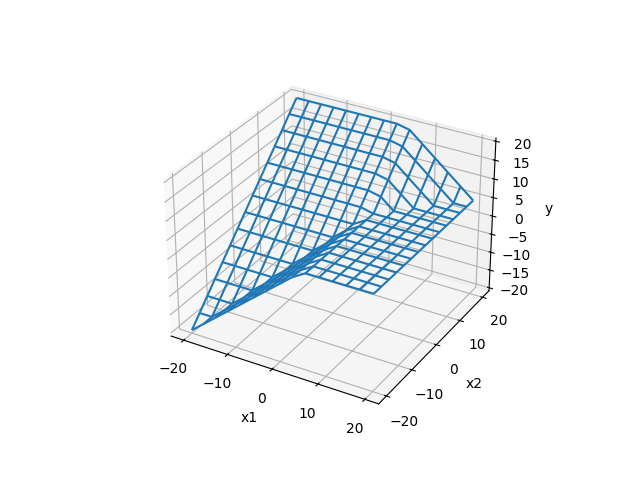

In [ ]:
n = 15                                  # numero di punti per l'asse x e per l'asse y
q = 20                                  # nuova estensione per la variabile indipendente
X1 = torch.linspace(-q, q, n).view(-1, 1).repeat(1, n).T
X2 = torch.linspace(-q, q, n).view(-1, 1).repeat(1, n)
XX1 = X1.reshape(n * n)
XX2 = X2.reshape(n * n)
X_test = torch.stack((XX1, XX2), dim=1)
Y_test = model(X_test)                  # calcola la previsione
Y1 = Y_test.reshape(n, n)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X1.detach().numpy(), X2.detach().numpy(), Y1.detach().numpy()) # type: ignore
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y') # type: ignore
plt.show()

... e poi anche calcolare qualche previsione...

In [44]:
X_test = torch.tensor([[10, 8.0]])      # punto di cui calcolare la previsione
Y_test = model(X_test)                  # calcola la previsione per il punto dato
print(f'La previsione per il punto ({X_test[0][0]}, {X_test[0][1]}) è {Y_test.item():.2f}')

La previsione per il punto (10.0, 8.0) è 4.93
